In [9]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.linear_model import BayesianRidge
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import ExtraTreeClassifier
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lightgbm
import catboost
import xgboost
#import shap
from scipy import interp
#import seaborn as sns
from catboost import *
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
#%matplotlib
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
###########loading data##########
fdata=pd.read_csv('database_filled_CD.csv',encoding="gbk")
raw_data=fdata.loc[:,[
                      'Operating Temperature (℃)',#0
                      'Flow Rate (mL min-1)',#1    
                      'Active Area (cm2)', #2
                      'Ir wt. %',#3
                      'Ru wt.%',#4
                      'O wt. %',#5
                      'I/C in Anode',#6
                      'Pt wt. %',#7
                      'I/C in Cathode',#8  
                      'Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)',#9
                      'Cathode Precious Metal Loading (mg cm-2 Pt/Pd)',#10
                      'Membrane Thickness (μm)',#11
                      'EW'#12
                        ]]
###########train test splitting##########
raw_param=raw_data.iloc[:,0:13]
print('ready')

ready


In [10]:
CD18=fdata.loc[:,['Current at 1.8 V']].values

In [11]:
def summarize(list1):
    total=0
    for ele in range(0, len(list1)):
        total = total + list1[ele]
    return total

In [12]:
def gridsearch(model,param,algorithm_name):
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    result = best_model.predict(X_test)
    x_prediction_07=result
    y_real_07=y_test[:,0]
    x_prediction_07_series=pd.Series(x_prediction_07)
    y_real_07_series=pd.Series(y_real_07)
    
    result_train = best_model.predict(X_train)
    x_prediction_07_train=result_train
    y_real_07_train=y_train[:,0]
    x_prediction_07_series_train=pd.Series(x_prediction_07_train)
    y_real_07_series_train=pd.Series(y_real_07_train)
    
    ###########evaluating the regression quality##########
    corr_ann = round(x_prediction_07_series.corr(y_real_07_series), 5)
    error_val= compute_mae_mse_rmse(x_prediction_07,y_real_07)
    
    corr_ann_train = round(x_prediction_07_series_train.corr(y_real_07_series_train), 5)
    error_val_train= compute_mae_mse_rmse(x_prediction_07_train,y_real_07_train)
    
    print(algorithm_name)
    print(best_model.feature_importances_)
    print('Best Regressor:',grid.best_params_,'Best Score:', grid.best_score_)
    print(error_val,'TEST R2',error_val[3],'TEST CORR',corr_ann)
    print(error_val_train,'TRAIN R2',error_val_train[3],'TRAIN CORR',corr_ann_train)
    x_y_x=np.arange(0,4.5,0.1)
    x_y_y=np.arange(0,4.5,0.1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_prediction_07,y_real_07,color='red',label=algorithm_name+' Test Set',alpha=0.75)
    ax.scatter(x_prediction_07_train,y_real_07_train,color='blue',label=algorithm_name+' Training Set',alpha=0.25,marker="^")
    ax.plot(x_y_x,x_y_y)
    plt.legend()
    plt.xlabel(u"Predicted_Current_Density (mA cm^-2)@1.8V (vs. RHE)")
    plt.ylabel(u"Real_Current_Density (mA cm^-2)@1.8V (vs. RHE)")
    plt.savefig('CD18 SEL %s.png' %algorithm_name)
    print('finished')
    return best_model

In [13]:
seed=7
X_train, X_test, y_train, y_test = train_test_split(raw_param, CD18, test_size=.15,random_state=seed)

In [14]:
from catboost import *
import shap
def shap_plot(model,param,algorithm_name):
    print(algorithm_name)
    SHAP_INPUT=raw_data.iloc[:,0:13]
    SHAP_OUTPUT=CD18
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-100)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT
    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    else:
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)

In [15]:
def shap_plot_interaction(best_model,algorithm_name,interacted_features):
    print(algorithm_name)
    SHAP_INPUT=raw_param
    SHAP_OUTPUT=CD18
    print('train finished')
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT.astype(np.float32)

    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.dependence_plot(interacted_features[0], shap_values, SHAP_INPUT,interaction_index= interacted_features[1])
        shap.dependence_plot(interacted_features[1], shap_values, SHAP_INPUT,interaction_index= interacted_features[0])
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,SHAP_INPUT)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)        
        interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(SHAP_INPUT) 
        print(shap_values)
        shap.dependence_plot(interacted_features[0], shap_values, SHAP_INPUT,interaction_index= interacted_features[1])
        shap.dependence_plot(interacted_features[1], shap_values, SHAP_INPUT,interaction_index= interacted_features[0])
    elif algorithm_name=='ANN':
        SHAP_INPUT=standardized_data.iloc[:,0:22]
        SHAP_OUTPUT=raw_data.iloc[:,22]
        X_SHAP=SHAP_INPUT.values.astype(np.float32)
        y_SHAP=SHAP_OUTPUT.values.astype(np.float32)
        explainer = shap.DeepExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP) 
        print(shap_values)
        shap.dependence_plot(interacted_features[0], shap_values[0], SHAP_INPUT,interaction_index= interacted_features[1])
        shap.dependence_plot(interacted_features[1], shap_values[0], SHAP_INPUT,interaction_index= interacted_features[0])
    else:
        explainer = shap.TreeExplainer(best_model,SHAP_INPUT)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(SHAP_INPUT)
        shap.dependence_plot(interacted_features[0], shap_values, SHAP_INPUT,interaction_index= interacted_features[1])
        shap.dependence_plot(interacted_features[1], shap_values, SHAP_INPUT,interaction_index= interacted_features[0])
from pdpbox import pdp
def plot_pdp_interact_ANN(model, df, f_list, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    inter1 = pdp.pdp_interact(model, df, model_features=df.columns.tolist(), features=f_list,num_grid_points=[20,20])
    # plot it
    settings = {
            'contour_color':  'white',
            'font_family': 'Arial',
            # matplotlib color map for interact plot
            'cmap': 'viridis',
            # fill alpha for interact plot
            'inter_fill_alpha': 0.8,
            # fontsize for interact plot text
            'inter_fontsize': 7,
        }
    pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=f_list, plot_type='contour',figsize=(10,10),x_quantile=True, plot_pdp=True,plot_params=settings)
from sklearn.inspection import plot_partial_dependence
from sklearn.utils import validation
def pdp_plot_2d(best_model,f_list):
    print('start')
    validation.check_is_fitted(estimator=best_model)
    my_plots =plot_partial_dependence(best_model, features=[f_list], X=raw_param, percentiles=(0, 1),grid_resolution=100,target=0)
def pdp_plot_2d_XG_CAT(best_model,f_list):
    print('start')
    best_model.dummy_ = "dummy"
    validation.check_is_fitted(estimator=best_model)
    my_plots =plot_partial_dependence(best_model, features=[f_list], X=raw_param, percentiles=(0, 1),grid_resolution=100,target=0)
def pdp_plot_2d_ANN(model,f_list):
    print('start')
    model.dummy_ = "dummy"
    print(type(model))
    validation.check_is_fitted(estimator=model)
    my_plots =plot_partial_dependence(model, features=[f_listt], X=raw_input, percentiles=(0, 1))

Random Forest
[0.1698075  0.06455354 0.04592815 0.04674506 0.02188419 0.05386286
 0.12169911 0.05455635 0.08733205 0.07346515 0.08000339 0.12681471
 0.05334794]
Best Regressor: {'criterion': 'mae', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200} Best Score: 0.7617597489549566
(0.28818631360189606, 0.1995357757277432, 0.44669427545889057, 0.7357989643627818) TEST R2 0.7357989643627818 TEST CORR 0.90163
(0.15402177560118108, 0.0840300321710379, 0.2898793407109894, 0.9087471522084506) TRAIN R2 0.9087471522084506 TRAIN CORR 0.96494
finished


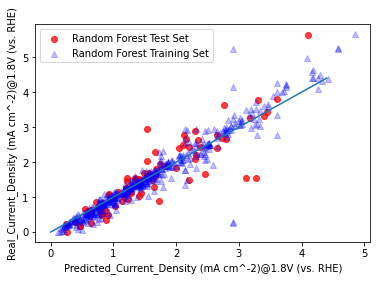

In [16]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
'n_estimators':[200],
'max_depth':[None],
'criterion':['mae'],
'max_features':['sqrt']
}
RF=gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')

In [17]:
inter_feature_list=[['Ir wt. %','Ru wt.%'],["Cathode Precious Metal Loading (mg cm-2 Pt/Pd)","I/C in Cathode"],['Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)','I/C in Anode'],['Membrane Thickness (μm)','EW']]

In [19]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [20]:
for inter_feature in inter_feature_list:
    shap_plot_interaction(RF,algorithm_name="Random Forest",interacted_features=inter_feature)

Random Forest
train finished


 94%|=================== | 541/578 [00:14<00:00]       

[[ 0.14339929 -0.02292045 -0.02714574 ...  0.04574482 -0.21515845
  -0.04593089]
 [ 0.14339929 -0.02292045 -0.02714574 ...  0.04574482 -0.21515845
  -0.04593089]
 [ 0.21557537  0.0255425   0.0061444  ...  0.14388437  0.23653269
   0.46173651]
 ...
 [ 0.16923377  0.01257752  0.06179398 ... -0.00624819 -0.14979341
  -0.04194041]
 [ 0.1540713   0.0064962   0.04518725 ... -0.010932   -0.15699615
  -0.04444289]
 [ 0.19505206  0.00283903  0.06255468 ... -0.00103088 -0.09546452
  -0.03140187]]
Random Forest
train finished


 98%|===================| 568/578 [00:23<00:00]        

[[ 0.14339929 -0.02292045 -0.02714574 ...  0.04574482 -0.21515845
  -0.04593089]
 [ 0.14339929 -0.02292045 -0.02714574 ...  0.04574482 -0.21515845
  -0.04593089]
 [ 0.21557537  0.0255425   0.0061444  ...  0.14388437  0.23653269
   0.46173651]
 ...
 [ 0.16923377  0.01257752  0.06179398 ... -0.00624819 -0.14979341
  -0.04194041]
 [ 0.1540713   0.0064962   0.04518725 ... -0.010932   -0.15699615
  -0.04444289]
 [ 0.19505206  0.00283903  0.06255468 ... -0.00103088 -0.09546452
  -0.03140187]]
Random Forest
train finished


 96%|=================== | 553/578 [00:14<00:00]       

[[ 0.14339929 -0.02292045 -0.02714574 ...  0.04574482 -0.21515845
  -0.04593089]
 [ 0.14339929 -0.02292045 -0.02714574 ...  0.04574482 -0.21515845
  -0.04593089]
 [ 0.21557537  0.0255425   0.0061444  ...  0.14388437  0.23653269
   0.46173651]
 ...
 [ 0.16923377  0.01257752  0.06179398 ... -0.00624819 -0.14979341
  -0.04194041]
 [ 0.1540713   0.0064962   0.04518725 ... -0.010932   -0.15699615
  -0.04444289]
 [ 0.19505206  0.00283903  0.06255468 ... -0.00103088 -0.09546452
  -0.03140187]]
Random Forest
train finished


 94%|=================== | 544/578 [00:14<00:00]       

[[ 0.14339929 -0.02292045 -0.02714574 ...  0.04574482 -0.21515845
  -0.04593089]
 [ 0.14339929 -0.02292045 -0.02714574 ...  0.04574482 -0.21515845
  -0.04593089]
 [ 0.21557537  0.0255425   0.0061444  ...  0.14388437  0.23653269
   0.46173651]
 ...
 [ 0.16923377  0.01257752  0.06179398 ... -0.00624819 -0.14979341
  -0.04194041]
 [ 0.1540713   0.0064962   0.04518725 ... -0.010932   -0.15699615
  -0.04444289]
 [ 0.19505206  0.00283903  0.06255468 ... -0.00103088 -0.09546452
  -0.03140187]]


In [21]:
for inter_feature in inter_feature_list:
    pdp_plot_2d(RF,inter_feature)

start
start
start
start
